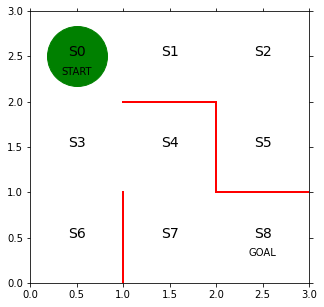

In [6]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(5,5))
ax = plt.gca()
"""
可视化用的，不影响数学建模
"""
plt.plot([1,1],[0,1],color='red',linewidth = 2)
plt.plot([1,2],[2,2],color='red',linewidth = 2)
plt.plot([2,2],[2,1],color='red',linewidth = 2)
plt.plot([2,3],[1,1],color='red',linewidth = 2)

plt.text(0.5,2.5,'S0',size=14,ha='center')
plt.text(1.5,2.5,'S1',size=14,ha='center')
plt.text(2.5,2.5,'S2',size=14,ha='center')
plt.text(0.5,1.5,'S3',size=14,ha='center')
plt.text(1.5,1.5,'S4',size=14,ha='center')
plt.text(2.5,1.5,'S5',size=14,ha='center')
plt.text(0.5,0.5,'S6',size=14,ha='center')
plt.text(1.5,0.5,'S7',size=14,ha='center')
plt.text(2.5,0.5,'S8',size=14,ha='center')

plt.text(0.5,2.3,'START',ha='center')
plt.text(2.5,0.3,'GOAL',ha ='center')

ax.set_xlim(0,3)
ax.set_ylim(0,3)
plt.tick_params(axis = 'both',which='both',bottom = 'off',top = 'off',
               labelbottom = 'off',right = 'off',left='off',labelleft = 'off')
line, = ax.plot(0.5,2.5,marker='o',color = 'g',markersize = 60)     #  移动object

In [7]:
theta_0 = np.array([[np.nan,1,1,np.nan],             #方案，用于转换为概率的值
                  [np.nan,1,np.nan,1],
                  [np.nan,np.nan,1,1],
                  [1,1,1,np.nan],
                  [np.nan,np.nan,1,1],
                  [1,np.nan,np.nan,np.nan],
                  [1,np.nan,np.nan,np.nan],
                  [1,1,np.nan,np.nan]])

def simple_convert_into_pi_from_theta(theta):   
    """
返回策略集合PI，各个状态的各个选择的概率，直接转换,既每一步策略随机选择，且大小不变，
    """
    beta = 0.1                           #   
    [m,n] = theta.shape
    pi = np.zeros((m,n))

    exp_theta = np.exp(beta * theta)   #e^(β*θ)
    for i in range(m):
        pi[i,:] = exp_theta[i,:]/np.nansum(exp_theta[i,:])
    pi = np.nan_to_num(pi)        #   矩阵中的空值转换为数字0
    
    return pi

pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [93]:
def get_next_s(pi,s): #随机策略到达下一个状态

    """
    pi策略
    s状态
    """
    direction = ['up','right','down','left']

    next_direction = np.random.choice(direction,p = pi[s,:])       #随机选择

    if next_direction == 'up':
        action = 0                                       #   a
        s_next = s-3                                     #   s'
    elif next_direction == 'right':                                         
        action = 1                                       #   a
        s_next = s+1                                     #   s'
    elif next_direction == 'down':
        action = 2                                       #   a
        s_next = s+3                                     #   s'
    elif next_direction == 'left':
        action = 3                                       #   a
        s_next = s-1                                     #   s'

    return [action,s_next]                              # 返回当前动作和状态

def goal_maze(pi):    #存储轨迹
    s = 0
    state_history = [0]

    while(1):
        next_s = get_next_s(pi,s)    #  调用get_next_s实现随机移动
        state_history.append(next_s)
        if next_s == 8:
            break
        else:
            s=next_s
    return state_history   #返回轨迹

def goal_maze_ret_s_a(pi):
    s = 0
    s_a_history = [[0,np.nan]]

    while(1):
        [action,next_s] = get_next_s(pi,s)
        s_a_history[-1][1] = action       
        s_a_history.append([next_s,np.nan])
        if next_s == 8:
            break
        else:
            s = next_s

    return s_a_history



In [71]:
# pi_0 是选择集合，[0,0,0.5,0.5]每个状态的各个策略以及概率
# action 动作分类，以数值区分，1234
# s状态，共九个状态0~8
# get_next_s返回动作和动作后状态组成的list
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)

def animate(i):
    state = s_a_history[1][i]
    x = (state % 3) + 0.5
    y = 2.5 - int(state / 3)
    line.set_data(x,y)
    return (line,)

anim = animation.FuncAnimation(fig,animate,init_func = init,frames=len(s_a_history[0]),interval = 200,repeat=False)

HTML(anim.to_jshtml())

ValueError: cannot convert float NaN to integer

# 更新策略

In [431]:
def softmax_convert_into_pi_from_theta(theta):
    beta = 1.0
    [m,n] = theta.shape
    pi = np.zeros((m,n))
    
    exp_theta = np.exp(beta *theta)
    for i in range(0,m):
        pi[i,:]=exp_theta[i,:]/np.nansum(exp_theta[i,:])
    pi = np.nan_to_num(pi)
    return pi

def updata_theta(theta, pi, s_a_history):
    """
    更新策略需要状态(s)和动作(a)的日志（或者说轨迹,历史）
    """
    eta = 0.2
    T = len(s_a_history) - 1
    """
     Π(theta)中theta的形状，策略参数集合的形状，m等于状态集合的维度，n等于action集合的维度
    """
    [m, n] = theta.shape
    delta_theta = theta.copy()

    """
    # SA list of state and action,SA[0] is state
    """
    for i in range(m):           #  状态维度m

        SA_i = [SA for SA in s_a_history if SA[0] == i]  # 状态为i时的SA集合,状态相同，动作不同
        N_i = len(SA_i)  # 状态i的集合大小

        for j in range(n):      #动作维度n
            SA_ij = [SA for SA in s_a_history if SA == [i, j]]
            """
            状态为i，动作为j的集合，SA_ij中所有元素相同
            """
            N_ij = len(SA_ij)
            
            delta_theta[i, j] = (N_ij-pi[i, j]*N_i)/T      # Δθ的更新量
            
    new_theta=theta+eta*delta_theta
    
    return new_theta


In [464]:
s_a_history = s_a_history = goal_maze_ret_s_a(pi_0)
print('求解迷宫所需的步数：'+str(len(s_a_history)-1))
eta = 0.2
T = len(s_a_history) - 1
delta_theta = theta_0.copy()
# for i in range(8):
i = 4
SA_i = [SA for SA in s_a_history if SA[0] == i]  # 状态为i时的SA集合,状态相同，动作不同
#     N_i = len(SA_i)  # 状态i的集合大小
print(SA_i)
for j in range(4):      #ACTION,1,2,3,4
    SA_ij = [SA for SA in s_a_history if SA == [i, j]]
    """
    状态为i，动作为j的集合，SA_ij中所有元素相同
    """
    print(SA_ij)
    N_ij = len(SA_ij)
    delta_theta[i, j] = (N_ij-pi[i, j]*N_i)/T      # Δθ的更新量
            

求解迷宫所需的步数：92
[[4, 2], [4, 2], [4, 3], [4, 2], [4, 3], [4, 3], [4, 2]]
[]
[]
[[4, 2], [4, 2], [4, 2], [4, 2]]
[[4, 3], [4, 3], [4, 3]]


In [465]:
import pandas as pd
print(pd.DataFrame(delta_theta,columns=['up','right','down','left']))
print(theta_0)

    up  right      down      left
0  NaN    1.0  1.000000       NaN
1  NaN    1.0       NaN  1.000000
2  NaN    NaN  1.000000  1.000000
3  1.0    1.0  1.000000       NaN
4  0.0    0.0  0.024533  0.029815
5  1.0    NaN       NaN       NaN
6  1.0    NaN       NaN       NaN
7  1.0    1.0       NaN       NaN
[[nan  1.  1. nan]
 [nan  1. nan  1.]
 [nan nan  1.  1.]
 [ 1.  1.  1. nan]
 [nan nan  1.  1.]
 [ 1. nan nan nan]
 [ 1. nan nan nan]
 [ 1.  1. nan nan]]


In [416]:
s_a_history = goal_maze_ret_s_a(pi)
# print(s_a_history)
print('求解迷宫所需的步数：'+str(len(s_a_history)-1))     
theta = updata_theta(theta,pi,s_a_history)   #  根据state,action更新policy参数

pi = softmax_convert_into_pi_from_theta(theta)
print(pi)

求解迷宫所需的步数：8
[[0.         0.25285851 0.74714149 0.        ]
 [0.         0.38002225 0.         0.61997775]
 [0.         0.         0.47013163 0.52986837]
 [0.17696728 0.60883914 0.21419358 0.        ]
 [0.         0.         0.79389885 0.20610115]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.2980621  0.7019379  0.         0.        ]]


In [92]:
stop_eplilon = 10**-4

theta = theta_0
pi = pi_0

is_continue = True
count=1
while is_continue:
    s_a_history = goal_maze_ret_s_a(pi)
    new_theta = updata_theta(theta,pi,s_a_history)
    new_pi = softmax_convert_into_pi_from_theta(new_theta)
    
    print(np.sum(np.abs(new_pi-pi)))
    
    if np.sum(np.abs(new_pi-pi)) <stop_eplilon:
        is_continue = False
    else:
        theta = new_theta
        pi = new_pi
        
        

[]
[[0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
[[0, 2], [0, 2], [0, 2]]
[]
[]
[[1, 1], [1, 1], [1, 1], [1, 1]]
[]
[[1, 3], [1, 3], [1, 3], [1, 3], [1, 3]]
[]
[]
[]
[[2, 3], [2, 3], [2, 3], [2, 3]]
[[3, 0], [3, 0]]
[[3, 1], [3, 1]]
[]
[]
[]
[]
[[4, 2], [4, 2]]
[[4, 3]]
[]
[]
[]
[]
[]
[]
[]
[]
[[7, 0]]
[[7, 1]]
[]
[]


In [ ]:
"""

theta   策略参数
pi：策略
策略更新函数
价值函数
"""
"""
将action和下一个s+1状态拆成两个函数
"""

def get_action(s, Q, epsilon, pi_0):
    """
    s是当前状态
    """
    direction = ['up', 'right', 'down', 'left']
    next_direction = np.random.choice(direction,p = pi_0[s,:])       #随机选择
    if np.random.rand() < eplison:
        next_direction = np.random.choice(direction,p = pi_0[s,:])    
    else:
    """
    np.nanargmax[]返回[]内最大值的索引
    """
        next_direction = direction[np.nanargmax(Q[s,:])]
        
    if next_direction == 'up':
        action = 0                                       #   a
    elif next_direction == 'right':                                         
        action = 1                                       #   a
    elif next_direction == 'down':
        action = 2                                       #   a
    elif next_direction == 'left':
        action = 3                                       #   a
           
    return action  

def get_s_next(s,a,Q,eplison,pi_0):
    # a = get_action()
    direction = ['up','right','down','left']
    next_direction = direction[a]
    
    if next_direction == 'up':
        s_next = s-3                                     #   s'
    elif next_direction == 'right':                                         
        s_next = s+1                                     #   s'
    elif next_direction == 'down':
        s_next = s+3                                     #   s'
    elif next_direction == 'left':
        s_next = s-1                                     #   s'
        
    return s_next

def Sarsa(s,a,r,s_next,a_next,eta,gamma,Q):
    if s_next == 8:
         Q[s,a] = gamma*Q[s

In [4]:
"""

theta   策略参数
pi：策略
策略更新函数
价值函数
将action和下一个s+1状态拆成两个函数
"""

def get_action(s, Q, epsilon, pi_0):   #有一定概率选择最大动作价值行动，返回action
    """
     s是当前状态 
     np.nanargmax[]返回[]内最大值的索引
     """
    direction = ['up', 'right', 'down', 'left']
    next_direction = np.random.choice(direction,p = pi_0[s,:])       #随机选择
    if np.random.rand() < epsilon:
        next_direction = np.random.choice(direction,p = pi_0[s,:])    
    else:
        next_direction = direction[np.nanargmax(Q[s,:])]
        
    if next_direction == 'up':
        action = 0                                       #   a
    elif next_direction == 'right':                                         
        action = 1                                       #   a
    elif next_direction == 'down':
        action = 2                                       #   a
    elif next_direction == 'left':
        action = 3                                       #   a
           
    return action  

def get_s_next(s,a):                 #返回动作a后的状态
    # a = get_action()
    direction = ['up','right','down','left']
    next_direction = direction[a]
    
    if next_direction == 'up':
        s_next = s-3                                     #   s'
    elif next_direction == 'right':                                         
        s_next = s+1                                     #   s'
    elif next_direction == 'down':
        s_next = s+3                                     #   s'
    elif next_direction == 'left':
        s_next = s-1                                     #   s'
        
    return s_next

def Sarsa(s,a,r,s_next,a_next,eta,gamma,Q):              #价值更新，迭代函数
    if s_next == 8:
        Q[s,a] = Q[s,a] + eta*(r-Q[s,a])
    else:
        Q[s,a] = Q[s,a]+eta*(r+gamma*np.nanmax(Q[s_next,:])-Q[s,a])    #Q学习
#          Q[s,a] = Q[s,a]+eta*(r+gamma*Q[s_next,a_next]-Q[s,a])        #Sarsa
    return Q
                             
        
def goal_maze_ret_s_a_Q(Q,epsilon,eta,gamma,pi):     #返回路径和价值
    s = 2
    a = a_next = get_action(s,Q,epsilon,pi)
    s_a_history  = [[2,np.nan]]
    
    while (1):
        a = a_next
        s_a_history[-1][1] = a
        s_next = get_s_next(s,a)
        s_a_history.append([s_next,np.nan])
        if s_next == 8:
            r = 1
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next,Q,epsilon,pi)
        Q = Sarsa(s,a,r,s_next,a_next,eta,gamma,Q)    
        
        if s_next == 8:
            break
        else:
            s = s_next
    return [s_a_history,Q]

In [96]:
a,b = theta_0.shape

Q = np.random.rand(a,b)*theta_0*0.1  #价值函数集合，是一个矩阵
print(Q)

[[       nan 0.05212935 0.09535521        nan]
 [       nan 0.01547556        nan 0.06781708]
 [       nan        nan 0.04417814 0.01611893]
 [0.02913839 0.07386622 0.03657124        nan]
 [       nan        nan 0.03310192 0.00776674]
 [0.03040912        nan        nan        nan]
 [0.01709737        nan        nan        nan]
 [0.07195398 0.06110752        nan        nan]]


In [9]:
import pandas as pd
epsilon = 1

In [97]:
#  %debug
s_a_history,Q = goal_maze_ret_s_a_Q(Q,epsilon,0.3,0.1,pi_0)
epsilon = epsilon/2
print(s_a_history)
print(pd.DataFrame(Q,columns=['up', 'right', 'down', 'left']))

[[2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 1], [4, 2], [7, 0], [4, 2], [7, 1], [8, nan]]
         up     right      down      left
0       NaN  0.052129  0.068965       NaN
1       NaN  0.015476       NaN  0.050333
2       NaN       NaN  0.011945  0.013318
3  0.029138  0.052699  0.036571       NaN
4       NaN       NaN  0.019564  0.007767
5  0.008797       NaN       NaN       NaN
6  0.017097       NaN       NaN       NaN
7  0.051128  0.342775       NaN       NaN


In [98]:
"""
v某回合每个状态Q的最大值
V，v的集合
"""
v=np.nanmax(Q,axis=1)
is_continue = True
episode = 1
V=[]
V.append(np.nanmax(Q,axis=1))

while is_continue:
    print("回合数："+str(episode))
    epsilon = epsilon/2
    s_a_history,Q = goal_maze_ret_s_a_Q(Q,epsilon,0.3,0.1,pi_0)
    new_v = np.nanmax(Q,axis=1)
    print(np.sum(np.abs(new_v-v)))
    v=new_v
    V.append(v)
    print("求解迷宫为题所需的步数是："+str(len(s_a_history)-1))
    episode = episode + 1
    if episode > 100:
        break

回合数：1
0.24804345434343855
求解迷宫为题所需的步数是：6
回合数：2
0.18472661424959316
求解迷宫为题所需的步数是：10
回合数：3
0.1538516927518842
求解迷宫为题所需的步数是：18
回合数：4
0.10634533130524194
求解迷宫为题所需的步数是：22
回合数：5
0.07574295654028909
求解迷宫为题所需的步数是：22
回合数：6
0.04939987934729547
求解迷宫为题所需的步数是：18
回合数：7
0.03370328498309651
求解迷宫为题所需的步数是：16
回合数：8
0.024930930620888293
求解迷宫为题所需的步数是：14
回合数：9
0.016736702359505872
求解迷宫为题所需的步数是：14
回合数：10
0.011567499504365522
求解迷宫为题所需的步数是：10
回合数：11
0.00868939654745888
求解迷宫为题所需的步数是：12
回合数：12
0.006128163128157907
求解迷宫为题所需的步数是：8
回合数：13
0.004549763687896573
求解迷宫为题所需的步数是：12
回合数：14
0.003275115273596467
求解迷宫为题所需的步数是：10
回合数：15
0.002361640066347394
求解迷宫为题所需的步数是：6
回合数：16
0.001726644035997779
求解迷宫为题所需的步数是：8
回合数：17
0.0012374783489089468
求解迷宫为题所需的步数是：6
回合数：18
0.0009183504117143295
求解迷宫为题所需的步数是：10
回合数：19
0.0006540095669922361
求解迷宫为题所需的步数是：6
回合数：20
0.0004746845273898622
求解迷宫为题所需的步数是：6
回合数：21
0.0003513449329179035
求解迷宫为题所需的步数是：8
回合数：22
0.00025317942822116986
求解迷宫为题所需的步数是：6
回合数：23
0.0001846121705485297
求解迷宫为题所需的步数是：6
回合数：24
0

In [99]:
import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)
def animate(i):
    line, = ax.plot([0.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[2.5],marker='s',color=cm.jet(V[i][1]),markersize=85)
    line, = ax.plot([2.5],[2.5],marker='s',color=cm.jet(V[i][2]),markersize=85)
    line, = ax.plot([0.5],[1.5],marker='s',color=cm.jet(V[i][3]),markersize=85)
    line, = ax.plot([1.5],[1.5],marker='s',color=cm.jet(V[i][4]),markersize=85)
    line, = ax.plot([2.5],[1.5],marker='s',color=cm.jet(V[i][5]),markersize=85)
    line, = ax.plot([0.5],[0.5],marker='s',color=cm.jet(V[i][6]),markersize=85)
    line, = ax.plot([1.5],[0.5],marker='s',color=cm.jet(V[i][7]),markersize=85)
    line, = ax.plot([2.5],[0.5],marker='s',color=cm.jet(1.0),markersize=85)
    
    return (line,)

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(V),interval=200,repeat=False)

HTML(anim.to_jshtml())

import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)
def animate(i):
    line, = ax.plot([0.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([2.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([0.5],[1.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[1.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([2.5],[1.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([0.5],[0.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[0.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([2.5],[0.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    
    return (line,)

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(V),interval=200,repeat=False)

HTML(anim.to_jshtml())

import matplotlib.cm as cm
from matplotlib import animation
from IPython.display import HTML

def init():
    line.set_data([],[])
    return (line,)
def animate(i):
    line, = ax.plot([0.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([2.5],[2.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([0.5],[1.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[1.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([2.5],[1.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([0.5],[0.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([1.5],[0.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    line, = ax.plot([2.5],[0.5],marker='s',color=cm.jet(V[i][0]),markersize=85)
    
    return (line,)

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(V),interval=200,repeat=False)

HTML(anim.to_jshtml())

epsilon = 0.5
s_a_history,Q = goal_maze_ret_s_a_Q(Q,epsilon,0.3,0.1,pi_0)